# Load Saved Models (Optional)

To load previously trained models instead of retraining:

# Explore the OGB Dataset

In [3]:
# Load MLP baseline model (uncomment to use)
# checkpoint = torch.load('models/mlp_baseline.pth')
# model = MLP(checkpoint['in_dim'], checkpoint['hidden_dim'], checkpoint['out_dim']).to(device)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# print(f"MLP model loaded with val_acc: {checkpoint['val_acc']:.4f}")

# Load GraphSAGE model (uncomment to use)
# checkpoint = torch.load('models/graphsage_model.pth')
# sage_model = GraphSAGE(
#     in_channels=checkpoint['in_channels'],
#     hidden_channels=checkpoint['hidden_channels'],
#     out_channels=checkpoint['out_channels'],
#     num_layers=checkpoint['num_layers']
# ).to(device)
# sage_model.load_state_dict(checkpoint['model_state_dict'])
# sage_optimizer = torch.optim.Adam(sage_model.parameters(), lr=0.001)
# sage_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# print(f"GraphSAGE model loaded with val_acc: {checkpoint['final_val_acc']:.4f}")

# Load embeddings (uncomment to use)
# saved_data = torch.load('models/graphsage_embeddings.pth')
# embeddings = saved_data['embeddings']
# predictions = saved_data['predictions']
# print(f"Loaded embeddings: {embeddings.shape}, predictions: {predictions.shape}")

In [4]:
from ogb.nodeproppred import NodePropPredDataset
import torch

dataset = NodePropPredDataset(name="ogbn-products")
graph, labels = dataset[0]

# Extract data
edge_index = torch.tensor(graph['edge_index'])
node_features = torch.tensor(graph['node_feat'])
labels = labels.squeeze()


c:\Users\maria\miniconda3\Lib\site-packages\ogb\nodeproppred\dataset.py:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_dict = torch.load(pre_processed_file_path)


In [5]:
import pandas as pd

df = pd.DataFrame({
    "degree": torch.bincount(edge_index[0]).numpy()
})
df.describe()


,degree
count,2.449029e+06
mean,5.051728e+01
std,9.590501e+01
min,0.000000e+00
25%,8.000000e+00
50%,2.600000e+01
75%,6.200000e+01
max,1.748100e+04


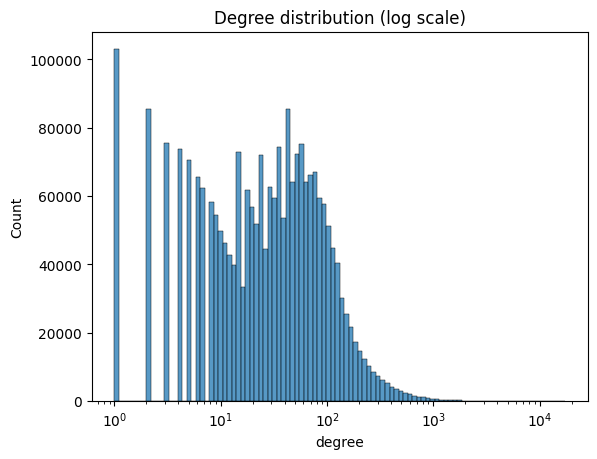

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df["degree"], log_scale=True, bins=100)
plt.title("Degree distribution (log scale)")
plt.show()


In [7]:
import networkx as nx

G = nx.Graph()
G.add_edges_from(edge_index.t().numpy())
components = nx.number_connected_components(G)


# Data Preprocessing

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# Ensure node_features is on CPU and convert to numpy for scaling
if isinstance(node_features, torch.Tensor):
    node_features_cpu = node_features.cpu().numpy()
else:
    node_features_cpu = node_features
node_features = torch.tensor(scaler.fit_transform(node_features_cpu), dtype=torch.float32)


In [9]:
degree = torch.bincount(edge_index[0])
cold_start_nodes = (degree <= 2).nonzero(as_tuple=True)[0]


In [10]:
pd.DataFrame({"node": cold_start_nodes.numpy()}).to_csv("cold_nodes.csv")


# Build and Train the Baseline Model

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim

print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


CUDA available: True
GPU name: NVIDIA GeForce RTX 3060


In [12]:
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, x):
        return self.net(x)


In [13]:
in_dim = node_features.shape[1]          # e.g., 100 for ogbn-products
hidden_dim = 256                         # baseline size

# Convert labels to tensor if needed for max calculation
if not isinstance(labels, torch.Tensor):
    labels_tensor = torch.tensor(labels)
else:
    labels_tensor = labels
out_dim = int(labels_tensor.max()) + 1   # number of classes (47 for ogbn-products)

model = MLP(in_dim, hidden_dim, out_dim).to(device)

# Get train/val/test split from OGB
split_idx = dataset.get_idx_split()
train_idx = torch.tensor(split_idx['train']).to(device)
val_idx = torch.tensor(split_idx['valid']).to(device)
test_idx = torch.tensor(split_idx['test']).to(device)

# Ensure tensors and move data to device
if not isinstance(node_features, torch.Tensor):
    node_features = torch.tensor(node_features)
node_features = node_features.to(device)

if not isinstance(labels, torch.Tensor):
    labels = torch.tensor(labels)
labels = labels.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()


In [14]:
epochs = 10  # baseline training duration

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    logits = model(node_features)
    loss = loss_fn(logits[train_idx], labels[train_idx])

    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}/{epochs} — Loss: {loss.item():.4f}")



Epoch 1/10 — Loss: 3.8713
Epoch 2/10 — Loss: 3.7953
Epoch 3/10 — Loss: 3.7224
Epoch 4/10 — Loss: 3.6524
Epoch 3/10 — Loss: 3.7224
Epoch 4/10 — Loss: 3.6524
Epoch 5/10 — Loss: 3.5852
Epoch 5/10 — Loss: 3.5852
Epoch 6/10 — Loss: 3.5206
Epoch 6/10 — Loss: 3.5206
Epoch 7/10 — Loss: 3.4584
Epoch 7/10 — Loss: 3.4584
Epoch 8/10 — Loss: 3.3984
Epoch 8/10 — Loss: 3.3984
Epoch 9/10 — Loss: 3.3404
Epoch 10/10 — Loss: 3.2843
Epoch 9/10 — Loss: 3.3404
Epoch 10/10 — Loss: 3.2843


In [15]:
model.eval()
with torch.no_grad():
    logits = model(node_features)
    preds = logits.argmax(dim=1)

val_acc = (preds[val_idx] == labels[val_idx]).float().mean().item()
print(f"Validation Accuracy (MLP Baseline): {val_acc:.4f}")


Validation Accuracy (MLP Baseline): 0.2729


In [16]:
# Save MLP baseline model
import os

os.makedirs('models', exist_ok=True)

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'in_dim': in_dim,
    'hidden_dim': hidden_dim,
    'out_dim': out_dim,
    'val_acc': val_acc
}, 'models/mlp_baseline.pth')

print(f"MLP baseline model saved to models/mlp_baseline.pth")
print(f"  Validation accuracy: {val_acc:.4f}")

MLP baseline model saved to models/mlp_baseline.pth
  Validation accuracy: 0.2729


# GraphSAGE Model with Multi-Hop Sampling

Now we implement GraphSAGE, a GNN that aggregates information from neighbors using sampling. This addresses the scalability issues with full-batch GNNs and is particularly relevant for cold-start nodes.

In [17]:
import torch
import torch.nn.functional as F
import numpy as np
from scipy import sparse

# Build adjacency matrix for neighbor sampling
num_nodes = node_features.shape[0]

# Create adjacency list from edge_index
adj_list = {i: [] for i in range(num_nodes)}
for src, dst in edge_index.t().numpy():
    adj_list[src].append(dst)
    adj_list[dst].append(src)  # undirected

print(f"Graph structure:")
print(f"  Nodes: {num_nodes}")
print(f"  Edges: {edge_index.shape[1]}")
print(f"  Features: {node_features.shape[1]}")
print(f"  Train nodes: {train_idx.shape[0]}")
print(f"  Val nodes: {val_idx.shape[0]}")
print(f"  Test nodes: {test_idx.shape[0]}")

Graph structure:
  Nodes: 2449029
  Edges: 123718280
  Features: 100
  Train nodes: 196615
  Val nodes: 39323
  Test nodes: 2213091


In [18]:
class SAGEConvLayer(torch.nn.Module):
    """GraphSAGE convolution layer - mean aggregation"""
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = torch.nn.Linear(2 * in_features, out_features)
    
    def forward(self, x, edge_index):
        # x: [N, in_features]
        # edge_index: [2, E]
        row, col = edge_index
        
        # Aggregate neighbors (mean aggregation)
        agg = torch.zeros(x.size(0), x.size(1), device=x.device)
        deg = torch.zeros(x.size(0), device=x.device)
        
        # Sum neighbors
        agg.index_add_(0, row, x[col])
        deg.index_add_(0, row, torch.ones(row.size(0), device=x.device))
        
        # Mean aggregation
        deg = deg.clamp(min=1).unsqueeze(1)
        agg = agg / deg
        
        # Concatenate self features with aggregated neighbor features
        out = torch.cat([x, agg], dim=1)
        out = self.linear(out)
        
        return out


class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=2):
        super().__init__()
        self.num_layers = num_layers
        self.convs = torch.nn.ModuleList()
        
        # First layer
        self.convs.append(SAGEConvLayer(in_channels, hidden_channels))
        
        # Hidden layers
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConvLayer(hidden_channels, hidden_channels))
        
        # Output layer
        self.convs.append(SAGEConvLayer(hidden_channels, out_channels))
    
    def forward(self, x, edge_index):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i < self.num_layers - 1:
                x = F.relu(x)
                x = F.dropout(x, p=0.5, training=self.training)
        return x


# Initialize GraphSAGE model
in_channels = node_features.shape[1]
hidden_channels = 256
num_classes = out_dim

sage_model = GraphSAGE(
    in_channels=in_channels,
    hidden_channels=hidden_channels,
    out_channels=num_classes,
    num_layers=2
).to(device)

print(f"GraphSAGE model created with {sum(p.numel() for p in sage_model.parameters())} parameters")

GraphSAGE model created with 75567 parameters


In [19]:
# Multi-hop neighbor sampling function
def sample_neighbors(nodes, adj_list, num_samples=[10, 5]):
    """
    Sample neighbors for multiple hops
    nodes: list of node indices
    adj_list: dict mapping node -> list of neighbors
    num_samples: list of number of neighbors to sample per hop
    Returns: all sampled nodes and subgraph edges
    """
    all_nodes = set(nodes)
    current_layer = set(nodes)
    edges = []
    
    for k in num_samples:
        next_layer = set()
        for node in current_layer:
            neighbors = adj_list.get(node, [])
            if len(neighbors) > 0:
                # Sample k neighbors (or all if less than k)
                sampled = np.random.choice(
                    neighbors, 
                    size=min(k, len(neighbors)), 
                    replace=False
                )
                for neighbor in sampled:
                    edges.append((node, neighbor))
                    next_layer.add(neighbor)
                    all_nodes.add(neighbor)
        current_layer = next_layer
    
    return list(all_nodes), edges


# Create mini-batches with neighbor sampling
def create_batches(node_indices, batch_size, adj_list, num_samples=[10, 5]):
    """Generate mini-batches with sampled neighborhoods"""
    indices = node_indices.cpu().numpy()
    np.random.shuffle(indices)
    
    batches = []
    for i in range(0, len(indices), batch_size):
        batch_nodes = indices[i:i+batch_size]
        sampled_nodes, sampled_edges = sample_neighbors(batch_nodes.tolist(), adj_list, num_samples)
        batches.append((batch_nodes, sampled_nodes, sampled_edges))
    
    return batches

print("Multi-hop neighbor sampling functions defined")
print("  Sampling strategy: [10, 5] neighbors per hop (2 hops)")

Multi-hop neighbor sampling functions defined
  Sampling strategy: [10, 5] neighbors per hop (2 hops)


In [20]:
# Training function for GraphSAGE with mini-batch
def train_sage_epoch(model, train_idx, batch_size, adj_list, node_feats, node_labels, 
                      edge_idx, optimizer, loss_fn, device, num_samples=[10, 5]):
    model.train()
    total_loss = 0
    total_examples = 0
    
    # Create batches
    batches = create_batches(train_idx, batch_size, adj_list, num_samples)
    
    for batch_target_nodes, sampled_nodes, sampled_edges in batches:
        optimizer.zero_grad()
        
        # Create node mapping for subgraph
        node_map = {n: i for i, n in enumerate(sampled_nodes)}
        
        # Get subgraph features and labels
        batch_x = node_feats[sampled_nodes].to(device)
        batch_y = node_labels[batch_target_nodes].to(device)
        
        # Create subgraph edge_index
        subgraph_edges = []
        for src, dst in sampled_edges:
            if src in node_map and dst in node_map:
                subgraph_edges.append([node_map[src], node_map[dst]])
        
        if len(subgraph_edges) > 0:
            batch_edge_index = torch.tensor(subgraph_edges, dtype=torch.long).t().to(device)
        else:
            batch_edge_index = torch.empty((2, 0), dtype=torch.long, device=device)
        
        # Forward pass
        out = model(batch_x, batch_edge_index)
        
        # Get predictions for target nodes only
        target_indices = [node_map[n] for n in batch_target_nodes if n in node_map]
        loss = loss_fn(out[target_indices], batch_y[:len(target_indices)])
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * len(target_indices)
        total_examples += len(target_indices)
    
    return total_loss / max(total_examples, 1)


# Evaluation function (mini-batch with neighbor sampling to avoid OOM)
@torch.no_grad()
def evaluate_sage(model, node_feats, node_labels, edge_idx, mask, device, 
                   adj_list, batch_size=2048, num_samples=[10, 5]):
    model.eval()
    
    # Get indices of nodes to evaluate
    eval_indices = mask.nonzero(as_tuple=True)[0].numpy()
    num_eval = len(eval_indices)
    
    all_preds = []
    all_labels = []
    
    # Process in batches with neighbor sampling
    for i in range(0, num_eval, batch_size):
        batch_target_nodes = eval_indices[i:i+batch_size]
        
        # Sample neighbors for this batch
        sampled_nodes, sampled_edges = sample_neighbors(batch_target_nodes.tolist(), adj_list, num_samples)
        node_map = {n: idx for idx, n in enumerate(sampled_nodes)}
        
        # Get subgraph features
        batch_x = node_feats[sampled_nodes].to(device)
        
        # Create subgraph edge_index
        subgraph_edges = []
        for src, dst in sampled_edges:
            if src in node_map and dst in node_map:
                subgraph_edges.append([node_map[src], node_map[dst]])
        
        if len(subgraph_edges) > 0:
            batch_edge_index = torch.tensor(subgraph_edges, dtype=torch.long).t().to(device)
        else:
            batch_edge_index = torch.empty((2, 0), dtype=torch.long, device=device)
        
        # Forward pass
        out = model(batch_x, batch_edge_index)
        
        # Get predictions for target nodes only
        target_indices = [node_map[n] for n in batch_target_nodes if n in node_map]
        pred = out[target_indices].argmax(dim=1).cpu()
        labels_batch = node_labels[batch_target_nodes[:len(target_indices)]]
        
        all_preds.append(pred)
        all_labels.append(labels_batch)
        
        # Clear GPU memory
        del out, batch_x, batch_edge_index
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    # Compute accuracy
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    correct = (all_preds == all_labels).sum()
    acc = correct.item() / len(all_labels)
    
    return acc

print("Training and evaluation functions defined")

Training and evaluation functions defined


In [21]:
# Train GraphSAGE model
sage_optimizer = torch.optim.Adam(sage_model.parameters(), lr=0.001)
sage_loss_fn = torch.nn.CrossEntropyLoss()

# Create masks as tensors
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[train_idx.cpu()] = True
val_mask[val_idx.cpu()] = True
test_mask[test_idx.cpu()] = True

epochs = 10
batch_size = 1024

print("Training GraphSAGE model with multi-hop sampling...")
print(f"Batch size: {batch_size}, Neighbor samples: [10, 5]")

for epoch in range(epochs):
    loss = train_sage_epoch(
        sage_model, train_idx, batch_size, adj_list, 
        node_features.cpu(), labels.cpu(), edge_index, 
        sage_optimizer, sage_loss_fn, device
    )
    
    if (epoch + 1) % 2 == 0:
        val_acc = evaluate_sage(sage_model, node_features.cpu(), labels.cpu(), 
                                 edge_index, val_mask, device, adj_list)
        print(f"Epoch {epoch+1}/{epochs} — Loss: {loss:.4f}, Val Acc: {val_acc:.4f}")
    else:
        print(f"Epoch {epoch+1}/{epochs} — Loss: {loss:.4f}")

print("\nTraining complete!")

Training GraphSAGE model with multi-hop sampling...
Batch size: 1024, Neighbor samples: [10, 5]
Epoch 1/10 — Loss: 1.1654
Epoch 1/10 — Loss: 1.1654
Epoch 2/10 — Loss: 0.5511, Val Acc: 0.8661
Epoch 2/10 — Loss: 0.5511, Val Acc: 0.8661
Epoch 3/10 — Loss: 0.4867
Epoch 3/10 — Loss: 0.4867
Epoch 4/10 — Loss: 0.4550, Val Acc: 0.8803
Epoch 4/10 — Loss: 0.4550, Val Acc: 0.8803
Epoch 5/10 — Loss: 0.4384
Epoch 5/10 — Loss: 0.4384
Epoch 6/10 — Loss: 0.4226, Val Acc: 0.8863
Epoch 6/10 — Loss: 0.4226, Val Acc: 0.8863
Epoch 7/10 — Loss: 0.4151
Epoch 7/10 — Loss: 0.4151
Epoch 8/10 — Loss: 0.4053, Val Acc: 0.8902
Epoch 8/10 — Loss: 0.4053, Val Acc: 0.8902
Epoch 9/10 — Loss: 0.3973
Epoch 9/10 — Loss: 0.3973
Epoch 10/10 — Loss: 0.3896, Val Acc: 0.8926

Training complete!
Epoch 10/10 — Loss: 0.3896, Val Acc: 0.8926

Training complete!


In [22]:
# Save GraphSAGE model
torch.save({
    'model_state_dict': sage_model.state_dict(),
    'optimizer_state_dict': sage_optimizer.state_dict(),
    'in_channels': in_channels,
    'hidden_channels': hidden_channels,
    'out_channels': num_classes,
    'num_layers': 2,
    'final_val_acc': val_acc  # from last validation
}, 'models/graphsage_model.pth')

print(f"GraphSAGE model saved to models/graphsage_model.pth")
print(f"  Final validation accuracy: {val_acc:.4f}")

GraphSAGE model saved to models/graphsage_model.pth
  Final validation accuracy: 0.8926


In [24]:
# Get embeddings and predictions using batched inference with neighbor sampling
sage_model.eval()

def get_embeddings_batched(model, node_feats, edge_idx, adj_list, device, 
                            batch_size=2048, num_samples=[10, 5]):
    """Generate embeddings for all nodes using batched inference"""
    num_nodes = node_feats.shape[0]
    all_embeddings = []
    all_predictions = []
    
    # Process all nodes in batches
    with torch.no_grad():
        for i in range(0, num_nodes, batch_size):
            batch_target_nodes = np.arange(i, min(i + batch_size, num_nodes))
            
            # Sample neighbors for this batch
            sampled_nodes, sampled_edges = sample_neighbors(batch_target_nodes.tolist(), adj_list, num_samples)
            node_map = {n: idx for idx, n in enumerate(sampled_nodes)}
            
            # Get subgraph features
            batch_x = node_feats[sampled_nodes].to(device)
            
            # Create subgraph edge_index
            subgraph_edges = []
            for src, dst in sampled_edges:
                if src in node_map and dst in node_map:
                    subgraph_edges.append([node_map[src], node_map[dst]])
            
            if len(subgraph_edges) > 0:
                batch_edge_index = torch.tensor(subgraph_edges, dtype=torch.long).t().to(device)
            else:
                batch_edge_index = torch.empty((2, 0), dtype=torch.long, device=device)
            
            # Forward pass through all layers
            x = batch_x
            for j, conv in enumerate(model.convs):
                x = conv(x, batch_edge_index)
                if j < len(model.convs) - 1:
                    # Get embeddings from second-to-last layer
                    if j == len(model.convs) - 2:
                        # Extract embeddings for target nodes
                        target_indices = [node_map[n] for n in batch_target_nodes if n in node_map]
                        batch_embeddings = F.relu(x[target_indices]).cpu()
                    x = F.relu(x)
            
            # Get predictions for target nodes
            target_indices = [node_map[n] for n in batch_target_nodes if n in node_map]
            batch_preds = x[target_indices].argmax(dim=1).cpu()
            
            all_embeddings.append(batch_embeddings)
            all_predictions.append(batch_preds)
            
            # Clear GPU memory
            del batch_x, batch_edge_index, x
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            
            if (i // batch_size + 1) % 100 == 0:
                print(f"  Processed {min(i + batch_size, num_nodes)}/{num_nodes} nodes...")
    
    embeddings = torch.cat(all_embeddings, dim=0)
    predictions = torch.cat(all_predictions, dim=0)
    return embeddings, predictions

print("Generating embeddings for all nodes (batched inference)...")
embeddings, predictions = get_embeddings_batched(
    sage_model, node_features.cpu(), edge_index, adj_list, device
)

print(f"Generated embeddings: {embeddings.shape}")
print(f"Predictions: {predictions.shape}")

Generating embeddings for all nodes (batched inference)...
  Processed 204800/2449029 nodes...
  Processed 204800/2449029 nodes...
  Processed 409600/2449029 nodes...
  Processed 409600/2449029 nodes...
  Processed 614400/2449029 nodes...
  Processed 614400/2449029 nodes...
  Processed 819200/2449029 nodes...
  Processed 819200/2449029 nodes...
  Processed 1024000/2449029 nodes...
  Processed 1024000/2449029 nodes...
  Processed 1228800/2449029 nodes...
  Processed 1228800/2449029 nodes...
  Processed 1433600/2449029 nodes...
  Processed 1433600/2449029 nodes...
  Processed 1638400/2449029 nodes...
  Processed 1638400/2449029 nodes...
  Processed 1843200/2449029 nodes...
  Processed 1843200/2449029 nodes...
  Processed 2048000/2449029 nodes...
  Processed 2048000/2449029 nodes...
  Processed 2252800/2449029 nodes...
  Processed 2252800/2449029 nodes...
Generated embeddings: torch.Size([2449029, 256])
Predictions: torch.Size([2449029])
Generated embeddings: torch.Size([2449029, 256])
Pr

In [25]:
# Save embeddings and predictions for later analysis
torch.save({
    'embeddings': embeddings,
    'predictions': predictions,
    'train_mask': train_mask,
    'val_mask': val_mask,
    'test_mask': test_mask,
    'cold_start_nodes': cold_start_nodes,
    'degree': degree
}, 'models/graphsage_embeddings.pth')

print(f"Embeddings and predictions saved to models/graphsage_embeddings.pth")
print(f"  Embeddings shape: {embeddings.shape}")
print(f"  Predictions shape: {predictions.shape}")

Embeddings and predictions saved to models/graphsage_embeddings.pth
  Embeddings shape: torch.Size([2449029, 256])
  Predictions shape: torch.Size([2449029])


In [27]:
# Analyze performance on cold-start nodes
# cold_start_nodes was defined earlier as nodes with degree <= 2
val_cold_mask = val_mask & (degree <= 2).cpu()
test_cold_mask = test_mask & (degree <= 2).cpu()

# Compute accuracy on different node groups
labels_cpu = labels.cpu()

val_acc_all = (predictions[val_mask] == labels_cpu[val_mask]).float().mean().item()
val_acc_cold = (predictions[val_cold_mask] == labels_cpu[val_cold_mask]).float().mean().item()

test_acc_all = (predictions[test_mask] == labels_cpu[test_mask]).float().mean().item()
test_acc_cold = (predictions[test_cold_mask] == labels_cpu[test_cold_mask]).float().mean().item()

print("=" * 60)
print("GraphSAGE Performance Analysis")
print("=" * 60)
print(f"Validation Accuracy (All nodes):        {val_acc_all:.4f}")
print(f"Validation Accuracy (Cold-start):       {val_acc_cold:.4f}")
print(f"Test Accuracy (All nodes):              {test_acc_all:.4f}")
print(f"Test Accuracy (Cold-start):             {test_acc_cold:.4f}")
print(f"\nCold-start nodes in val: {val_cold_mask.sum().item()}")
print(f"Cold-start nodes in test: {test_cold_mask.sum().item()}")
print(f"\nCold-start performance gap (val): {val_acc_all - val_acc_cold:.4f}")
print(f"Cold-start performance gap (test): {test_acc_all - test_acc_cold:.4f}")

GraphSAGE Performance Analysis
Validation Accuracy (All nodes):        0.8927
Validation Accuracy (Cold-start):       0.7464
Test Accuracy (All nodes):              0.7492
Test Accuracy (Cold-start):             0.6511

Cold-start nodes in val: 347
Cold-start nodes in test: 235990

Cold-start performance gap (val): 0.1463
Cold-start performance gap (test): 0.0982


Computing t-SNE for 1347 nodes...


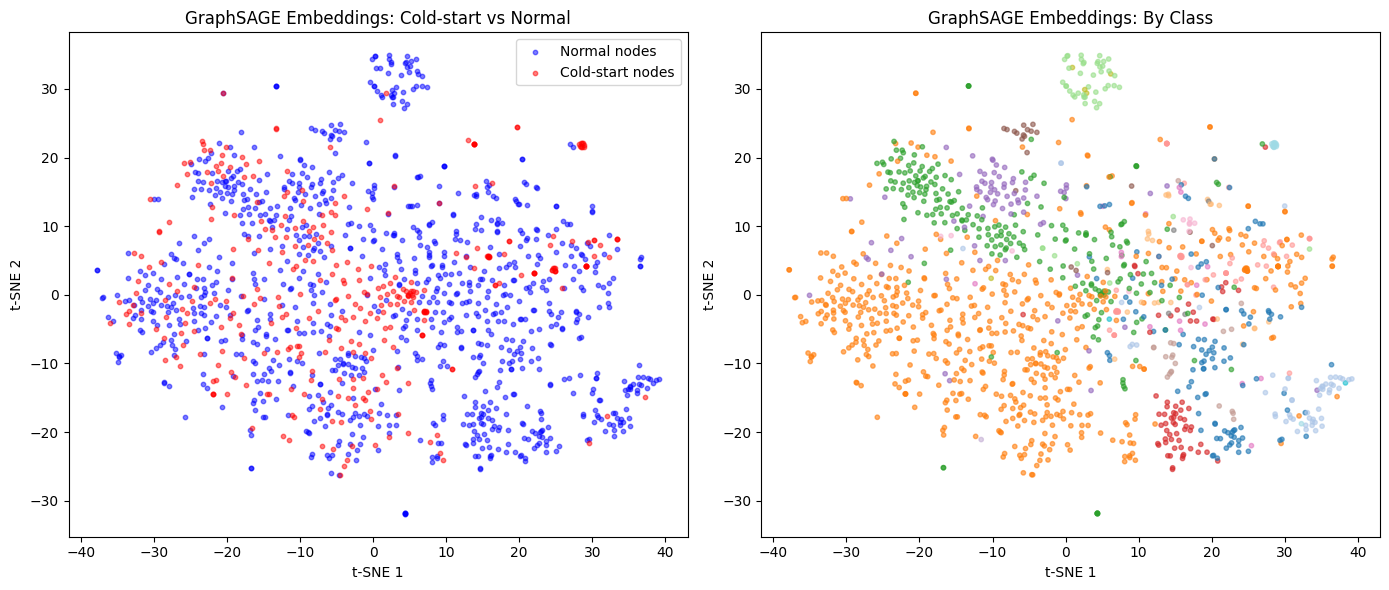

Visualization complete!


In [28]:
# Visualize embedding quality for cold-start vs normal nodes
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Sample nodes for visualization (too many to plot all)
np.random.seed(42)
sample_size = 2000

# Sample cold-start and normal nodes from validation set
val_indices = val_mask.nonzero(as_tuple=True)[0]
val_cold_indices = val_cold_mask.nonzero(as_tuple=True)[0]
val_normal_indices = val_mask & ~val_cold_mask
val_normal_indices = val_normal_indices.nonzero(as_tuple=True)[0]

# Sample balanced groups
n_cold = min(sample_size // 2, len(val_cold_indices))
n_normal = min(sample_size // 2, len(val_normal_indices))

cold_sample = val_cold_indices[np.random.choice(len(val_cold_indices), n_cold, replace=False)]
normal_sample = val_normal_indices[np.random.choice(len(val_normal_indices), n_normal, replace=False)]

# Combine samples
sample_indices = torch.cat([cold_sample, normal_sample])
sample_embeddings = embeddings[sample_indices].numpy()
sample_labels = labels_cpu[sample_indices].numpy()
is_cold = torch.cat([torch.ones(n_cold), torch.zeros(n_normal)]).numpy()

print(f"Computing t-SNE for {len(sample_indices)} nodes...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(sample_embeddings)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot by node type (cold-start vs normal)
axes[0].scatter(embeddings_2d[is_cold == 0, 0], embeddings_2d[is_cold == 0, 1], 
                c='blue', alpha=0.5, s=10, label='Normal nodes')
axes[0].scatter(embeddings_2d[is_cold == 1, 0], embeddings_2d[is_cold == 1, 1], 
                c='red', alpha=0.5, s=10, label='Cold-start nodes')
axes[0].set_title('GraphSAGE Embeddings: Cold-start vs Normal')
axes[0].legend()
axes[0].set_xlabel('t-SNE 1')
axes[0].set_ylabel('t-SNE 2')

# Plot by class label
scatter = axes[1].scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                          c=sample_labels, cmap='tab20', alpha=0.6, s=10)
axes[1].set_title('GraphSAGE Embeddings: By Class')
axes[1].set_xlabel('t-SNE 1')
axes[1].set_ylabel('t-SNE 2')

plt.tight_layout()
plt.show()

print("Visualization complete!")